In [17]:
!pip install -q tensorflow_similarity #hopsworks urllib3==1.26.0

In [3]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd

from PIL import Image
from os import listdir
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow_similarity.losses import MultiSimilarityLoss
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [4]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
!git clone https://github.com/AdrianHRedhe/ID2223_Project.git

Cloning into 'ID2223_Project'...
remote: Enumerating objects: 28882, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 28882 (delta 39), reused 144 (delta 31), pack-reused 28730
Receiving objects: 100% (28882/28882), 356.04 MiB | 27.05 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (28774/28774), done.


# ARGS

In [18]:
gdrive_base_dir = '/content/drive/MyDrive/ID2223 - Project/'
git_base_dir = 'ID2223_Project/'

base_dir = gdrive_base_dir
metadata_df = pd.read_csv(f'{base_dir}current_images_metadata.csv')

model_version = 'V5'
dataset_version = 'v1'

UPDATE_EMBEDDINGS_HOPSWORKS = False
READ_EMBEDDINGS_VIA_HOPSWORKS = False
READ_METADATA_VIA_HOPSWORKS = False

if READ_METADATA_VIA_HOPSWORKS:
    import hopsworks
    project = hopsworks.login(api_key_value='3AUfzmkHodq2ve3J.kh15KYDb6Xckmn3QZnS5VN9JlX8BHYgAs8jO9xRXggnMEnW2Y9M2JQDZybAM8IX9')
    fs = project.get_feature_store()

    image_meta_data_fg = fs.get_feature_group('image_metadata_fg',version = 1)
    metadata_df = image_meta_data_fg.read(read_options={"use_hive": True})

if not dataset_version == None:
    metadata_df = metadata_df[metadata_df['dataset_version'] == dataset_version]

## Make the images accessible from dict for convenience

In [19]:
def from_path_to_image(path):
    bgr_image = cv2.imread(path)
    rgb_image = bgr_image[:, :, ::-1]
    return rgb_image

In [20]:
path_to_img_dict = {}
paths = metadata_df.path_to_image.unique()

# 45 min when reading from gdrive vs 19 sec when copied info to colab

for i,path in enumerate(paths):
    path_to_img_dict[path] = np.array(from_path_to_image(path))

    if i % 2000 == 99:
        print(i, datetime.now())

99 2024-01-08 03:14:25.218434
2099 2024-01-08 03:14:28.605655
4099 2024-01-08 03:14:32.046165
6099 2024-01-08 03:14:36.642070
8099 2024-01-08 03:14:40.987379
10099 2024-01-08 03:14:44.393051


## Split the data

In [21]:
training_metadata_df = metadata_df[metadata_df.dataset_type == 'Training']
validation_metadata_df = metadata_df[metadata_df.dataset_type == 'Validation']
test_metadata_df = metadata_df[metadata_df.dataset_type == 'Test']

## Load the model
To load it we do need to define the GeM layer   
since the model has a lambda layer with GeM

In [22]:
# GeM layer as described here https://arxiv.org/abs/1711.02512 and
# implemented https://github.com/filipradenovic/cnnimageretrieval-pytorch
# on their github, but adapted for Tensorflow

# Original implementation, I have checked that both do give the same output.
# x = F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1./self.p)

def GeM(x):
  # Can make this hyper-param trainable but will not for now
  p = 3

  x = tf.math.maximum(x, 1e-6)
  x = tf.pow(x, p)
  x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)
  x = tf.pow(x, 1.0 / p)
  return x

In [23]:
model_names = [x for x in listdir(gdrive_base_dir+'models/') if ('model_' in x) & (not '.' in x)]
model_names = sorted(model_names)
model_names

['model_V1_freeze40_noDenseLayerInAGG_noRescalingPreRes_batch32_epochs1',
 'model_V2_freeze40_WithDenseLayerInAGG_OutDim2048_noRescalingPreRes_batch32_epochs6',
 'model_V3_freeze40_DenseLayerFalse_OutDim2048_rescalingFalse_batch32_epochs6',
 'model_V4_freeze20_DenseLayerTrue_OutDim512_rescalingFalse_batch32_epochs3',
 'model_V4_freeze20_DenseLayerTrue_OutDim512_rescalingFalse_batch32_epochs6',
 'model_V5_freeze20_DenseLayerTrue_OutDim2048_rescalingTrue_batch32_epochs6',
 'model_V6_freeze0_DenseLayerTrue_OutDim512_rescalingTrue_batch32_epochs6',
 'model_V7_freeze60_DenseLayerTrue_DenseActivationFunc=RELU_OutDim512_rescalingFalse_batch32_epochs4']

In [24]:
chosen_model = 1
model_path = gdrive_base_dir+'models/'+model_names[chosen_model]
model = models.load_model(model_path)
print(f'{model_names[chosen_model]}')

model_V2_freeze40_WithDenseLayerInAGG_OutDim2048_noRescalingPreRes_batch32_epochs6


### Generate Embeddings for all non-query images

In [25]:
# Helper class for visualising the Sim search
class neighbor_info:
    def __init__(self,label,data,distance):
        self.label = label
        self.data = data
        self.distance = distance

In [60]:
dataset = test_metadata_df
query = dataset[dataset.is_query_image == True]
database = dataset[dataset.is_query_image == False]

In [63]:
database_paths = database.path_to_image.to_list()
database_images = [path_to_img_dict[path] for path in database_paths]
database_images = np.array(database_images)

query_paths = query.path_to_image.to_list()
query_images = [path_to_img_dict[path] for path in query_paths]

In [62]:
# We can read the embeddings via
# if READ_EMBEDDINGS_VIA_HOPSWORKS:


# If we are calculating the embeddings for the first time we can save them to a feature store
if not READ_EMBEDDINGS_VIA_HOPSWORKS:
    database_embeddings = model.predict(database_images)

    if UPDATE_EMBEDDINGS_HOPSWORKS:
        print('Would update here but actually impossible to versioning with \
                jinja2 actually have to load to gdrive and upload from \
                separate colab notebook due to conflicts betweem packages')

69/69 [==============================] - 423s 6s/step


### Lets save these features for later

In [65]:
embedding_df = database.copy()
embedding_df['embeddings'] = list(database_embeddings)
embedding_df.to_csv(gdrive_base_dir+'Data/embeddings/embeddings_test_v1_000-001.csv',index=False)

In [66]:
embedding_df.dataset_shard.unique()

array([1, 2])

In [67]:
embedding_df

,new_order_idx,rotation_nr,picture_nr,taken_at,scraped_at,path_to_image,dataset_shard,dataset_type,dataset_version,buffer_meters,sorted_idx,location_idx,google_location,panoid,is_query_image,embeddings
22921,5014,0,1,2020-07-01,2024-01-05 15:02:39.694295,ID2223_Project/data/images/Cropped_Validation_...,1,Validation,v1,35,311,163595,"59.32299250499513, 18.07510939408347",KKwPi50cNgRP9byZwn6H1g,False,"[-0.02614519, -0.01898771, 0.006494556, 0.0036..."
22922,5014,0,2,2019-06-01,2024-01-05 15:02:47.759544,ID2223_Project/data/images/Cropped_Validation_...,1,Validation,v1,35,311,163595,"59.32299250499513, 18.07510939408347",KKwPi50cNgRP9byZwn6H1g,False,"[-0.026945176, -0.01738073, 0.006163972, 0.003..."
22923,5014,0,3,2017-07-01,2024-01-05 15:02:57.042212,ID2223_Project/data/images/Cropped_Validation_...,1,Validation,v1,35,311,163595,"59.32299250499513, 18.07510939408347",KKwPi50cNgRP9byZwn6H1g,False,"[-0.026052823, -0.018495338, 0.0063477824, 0.0..."
22924,5014,0,4,2016-05-01,2024-01-05 15:03:06.324973,ID2223_Project/data/images/Cropped_Validation_...,1,Validation,v1,35,311,163595,"59.32299250499513, 18.07510939408347",KKwPi50cNgRP9byZwn6H1g,False,"[-0.016282694, -0.019093933, 0.006011468, 5.85..."
22925,5014,0,5,2014-05-01,2024-01-05 15:03:16.419047,ID2223_Project/data/images/Cropped_Validation_...,1,Validation,v1,35,311,163595,"59.32299250499513, 18.07510939408347",KKwPi50cNgRP9byZwn6H1g,False,"[-0.025807813, -0.018242283, 0.005982731, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25455,5295,3,2,2020-07-01,2024-01-06 14:29:08.177142,ID2223_Project/data/images/Cropped_Validation_...,2,Validation,v1,35,9155,147029,"59.33749533210153, 18.06894969215303",QA1jMT4Bc7zX77-eCzzWaA,False,"[-0.024976954, -0.017702315, 0.0057617216, 0.0..."
25456,5295,3,3,2017-05-01,2024-01-06 14:29:19.327869,ID2223_Project/data/images/Cropped_Validation_...,2,Validation,v1,35,9155,147029,"59.33749533210153, 18.06894969215303",QA1jMT4Bc7zX77-eCzzWaA,False,"[-0.024990795, -0.017892025, 0.0059859087, 0.0..."
25457,5295,3,4,2014-06-01,2024-01-06 14:29:29.185189,ID2223_Project/data/images/Cropped_Validation_...,2,Validation,v1,35,9155,147029,"59.33749533210153, 18.06894969215303",QA1jMT4Bc7zX77-eCzzWaA,False,"[-0.026794527, -0.018055864, 0.0063080806, 0.0..."
25458,5295,3,5,2011-06-01,2024-01-06 14:29:39.855684,ID2223_Project/data/images/Cropped_Validation_...,2,Validation,v1,35,9155,147029,"59.33749533210153, 18.06894969215303",QA1jMT4Bc7zX77-eCzzWaA,False,"[-0.026161322, -0.017776167, 0.0061588697, 0.0..."


#### Put the embedings in the similarity search model

In [ ]:
kdtree = KDTree(database_embeddings)

In [ ]:
def pick_random_query(query_images):
    rand_index = np.random.randint(len(query_images))
    rand_query = query_images[rand_index]
    rand_query = np.array(rand_query).reshape(-1,224,224,3)
    print(f'Querying: {rand_index}')
    return rand_query

In [ ]:
def find_nearest_and_visualise(rand_query, model, kdtree):
    query_embedding = model.predict(rand_query)
    distances, indices = kdtree.query(query_embedding, k=5)
    images = database_images[indices][0]
    nearest_neighbours = [neighbor_info(f'{i+1} closest',images[i],distances[0][i]) for i in range(5)]
    fig = viz_neigbors_imgs(rand_query.reshape(224,224,3), 'Actual', nearest_neighbours, show=False)
    fig.savefig('test3.png')
    fig.show()
    return

Querying: 84
1/1 [==============================] - 0s 220ms/step


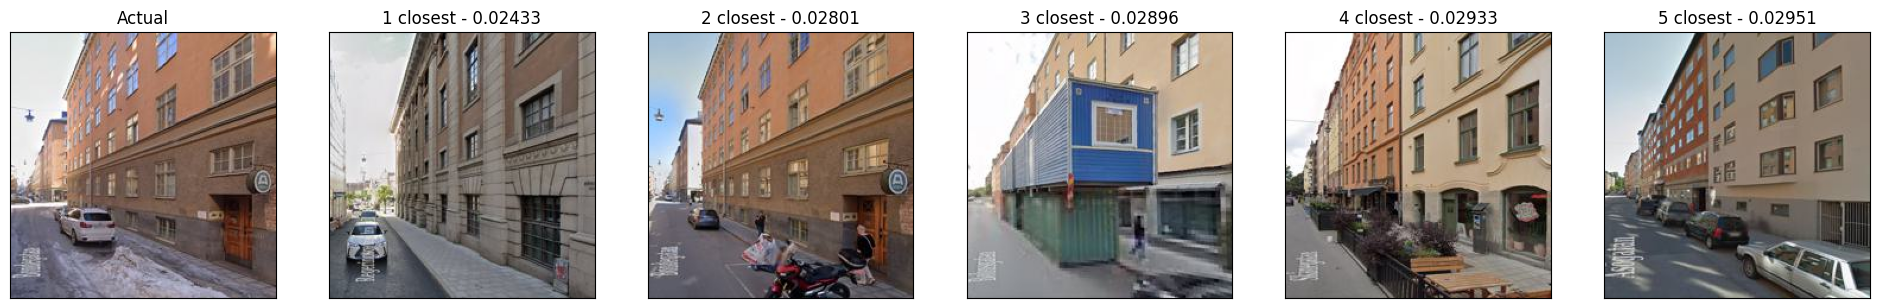

In [ ]:
rand_query = pick_random_query(query_images)
find_nearest_and_visualise(rand_query, model, kdtree)

In [ ]:
# 176 Gick bra

1/1 [==============================] - 0s 475ms/step


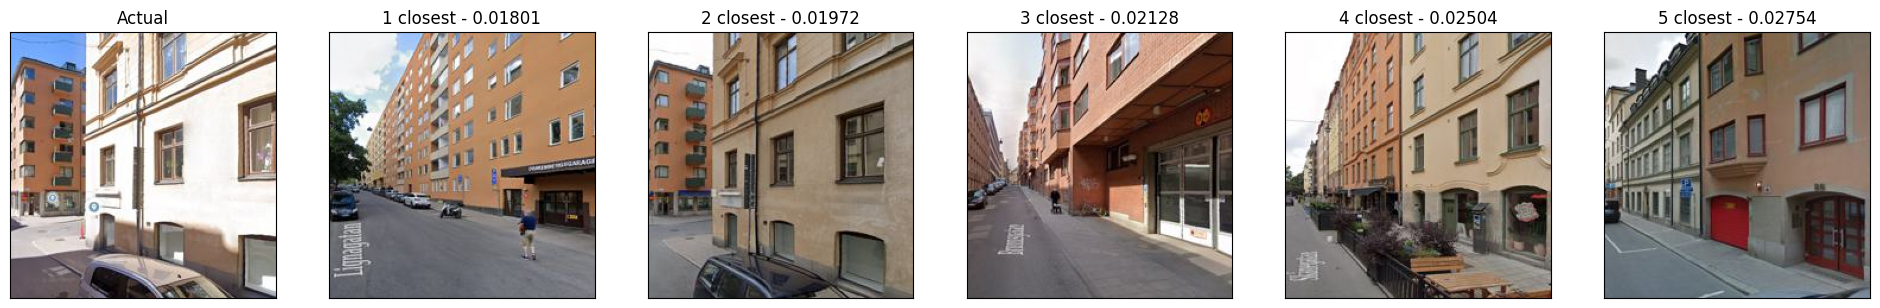

In [ ]:
find_nearest_and_visualise(rand_query, model, kdtree)

1/1 [==============================] - 1s 639ms/step


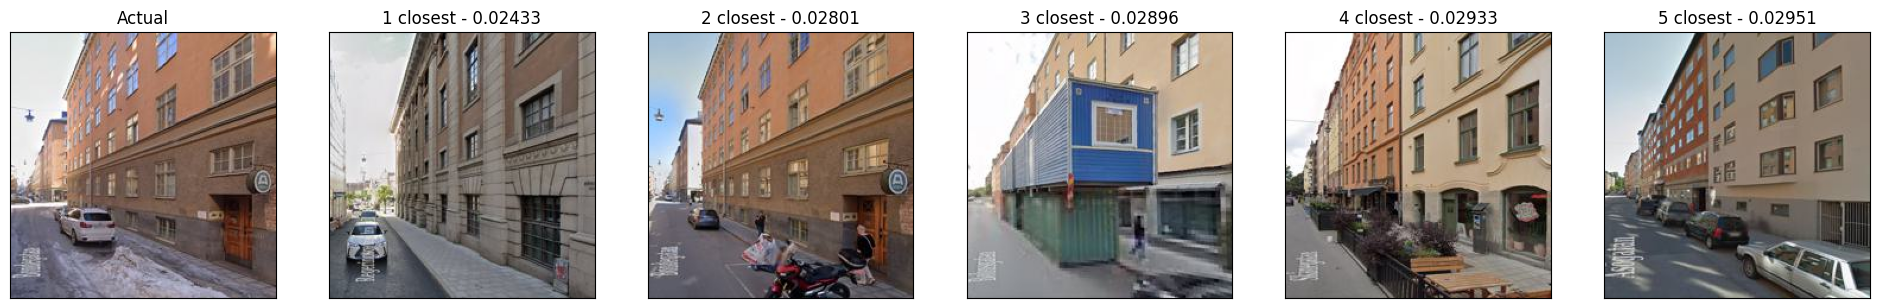

In [ ]:
find_nearest_and_visualise(rand_query, model, kdtree)